In [2]:
import pandas as pd
from libri_dataframe import build_librispeech_dataframe

LIBRISPEECH_ROOT = "./my_librispeech/LibriSpeech"
LIBRISPEECH_SUBSET = "test-clean"

dataframe = build_librispeech_dataframe(
    librispeech_root=LIBRISPEECH_ROOT,
    subset=LIBRISPEECH_SUBSET,
)


ModuleNotFoundError: No module named 'libri_dataframe'

In [2]:
dataframe_10 = dataframe[:10]

In [3]:
dataframe_10

,speaker_id,chapter_id,utterance_id,audio_path,transcript
0,1089,134686,0000,my_raw_audio/LibriSpeech/test-clean/1089/13468...,HE HOPED THERE WOULD BE STEW FOR DINNER TURNIP...
1,1089,134686,0001,my_raw_audio/LibriSpeech/test-clean/1089/13468...,STUFF IT INTO YOU HIS BELLY COUNSELLED HIM
2,1089,134686,0002,my_raw_audio/LibriSpeech/test-clean/1089/13468...,AFTER EARLY NIGHTFALL THE YELLOW LAMPS WOULD L...
3,1089,134686,0003,my_raw_audio/LibriSpeech/test-clean/1089/13468...,HELLO BERTIE ANY GOOD IN YOUR MIND
4,1089,134686,0004,my_raw_audio/LibriSpeech/test-clean/1089/13468...,NUMBER TEN FRESH NELLY IS WAITING ON YOU GOOD ...
5,1089,134686,0005,my_raw_audio/LibriSpeech/test-clean/1089/13468...,THE MUSIC CAME NEARER AND HE RECALLED THE WORD...
6,1089,134686,0006,my_raw_audio/LibriSpeech/test-clean/1089/13468...,THE DULL LIGHT FELL MORE FAINTLY UPON THE PAGE...
7,1089,134686,0007,my_raw_audio/LibriSpeech/test-clean/1089/13468...,A COLD LUCID INDIFFERENCE REIGNED IN HIS SOUL
8,1089,134686,0008,my_raw_audio/LibriSpeech/test-clean/1089/13468...,THE CHAOS IN WHICH HIS ARDOUR EXTINGUISHED ITS...
9,1089,134686,0009,my_raw_audio/LibriSpeech/test-clean/1089/13468...,AT MOST BY AN ALMS GIVEN TO A BEGGAR WHOSE BLE...


## 셜록홈즈 목소리로 10개 텍스트에 대해서 음성합성

In [4]:
import requests
import base64
import os
import json
import time

# 1. 서버 설정 (vllm 서버가 실행 중인 주소)
SERVER_URL = "http://localhost:8000/tts/zero-shot"
OUTPUT_DIR = "generated_results"

# 결과 저장 디렉토리 생성
os.makedirs(OUTPUT_DIR, exist_ok=True)

def save_audio(text, prompt_text, filename, prompt_wav_path=None, seed=None):
    """
    서버에 TTS 요청을 보내고 오디오 파일을 저장하는 함수
    """
    payload = {
        "text": text,
        "prompt_text": prompt_text,
        # prompt_wav_path는 서버 로컬 경로여야 합니다. 
        # None으로 보내면 서버의 DEFAULT_PROMPT_PATH를 사용합니다.
        "prompt_wav_path": prompt_wav_path, 
        "seed": seed
    }

    try:
        start_time = time.time()
        print(f"요청 중... Text: {text[:30]}...")

        response = requests.post(SERVER_URL, json=payload)

        if response.status_code == 200:
            data = response.json()
            audio_base64 = data["audio_base64"]

            # Base64 디코딩
            audio_bytes = base64.b64decode(audio_base64)

            # 파일 저장
            file_path = os.path.join(OUTPUT_DIR, filename)
            with open(file_path, "wb") as f:
                f.write(audio_bytes)

            elapsed = time.time() - start_time
            print(f"✅ 저장 완료: {file_path} (소요시간: {elapsed:.2f}초)")

        else:
            print(f"❌ 에러 발생: {response.status_code} - {response.text}")

    except Exception as e:
        print(f"❌ 연결 실패: {e}")

# 2. LibriSpeech 전사 문장에서 생성할 데이터 리스트 구성
input_rows = dataframe_10[['transcript', 'audio_path']].to_dict('records')
input_data = []
for idx, row in enumerate(input_rows):
    base_name = os.path.splitext(os.path.basename(row['audio_path']))[0]
    input_data.append({
        "text": row['transcript'],
        "filename": f"libri_transcript_{base_name}.wav",
        "seed": 2024 + idx  # 재현 가능한 출력을 위해 각 문장마다 고유 시드 부여
    })

# 3. 메인 실행 루프
if __name__ == "__main__":
    # CosyVoice 공식 데모/README에서 자주 사용되는 영어 프롬프트 텍스트
    # (서버의 기본 asset/zero_shot_prompt.wav 파일 내용과 일치해야 품질이 가장 좋습니다)
    COMMON_PROMPT_TEXT = "So maybe, that you would prefer to forgo my secret rather than consent to becoming a prisoner here for what might be several days."

    # 서버상의 프롬프트 오디오 파일 절대/상대 경로 (서버 코드 기준)
    # None으로 두면 서버의 기본값(asset/zero_shot_prompt.wav)을 사용합니다.
    SERVER_SIDE_WAV_PATH = "/mnt/ddn/kyudan/CosyVoice/asset/sherlock_prompt.wav"

    print(f"총 {len(input_data)}개의 오디오 생성을 시작합니다.")
    print(f"사용된 프롬프트: {COMMON_PROMPT_TEXT}")

    for idx, item in enumerate(input_data, start=1):
        print(f"[{idx:02d}/{len(input_data):02d}] 텍스트: {item['text'][:50]}...")
        save_audio(
            text=item["text"],
            prompt_text=COMMON_PROMPT_TEXT,
            filename=item["filename"],
            prompt_wav_path=SERVER_SIDE_WAV_PATH,
            seed=item.get("seed")
        )

    print("모든 작업이 완료되었습니다.")


총 10개의 오디오 생성을 시작합니다.
사용된 프롬프트: So maybe, that you would prefer to forgo my secret rather than consent to becoming a prisoner here for what might be several days.
[01/10] 텍스트: HE HOPED THERE WOULD BE STEW FOR DINNER TURNIPS AN...
요청 중... Text: HE HOPED THERE WOULD BE STEW F...
✅ 저장 완료: generated_results/libri_transcript_1089-134686-0000.wav (소요시간: 1.88초)
[02/10] 텍스트: STUFF IT INTO YOU HIS BELLY COUNSELLED HIM...
요청 중... Text: STUFF IT INTO YOU HIS BELLY CO...
✅ 저장 완료: generated_results/libri_transcript_1089-134686-0001.wav (소요시간: 0.92초)
[03/10] 텍스트: AFTER EARLY NIGHTFALL THE YELLOW LAMPS WOULD LIGHT...
요청 중... Text: AFTER EARLY NIGHTFALL THE YELL...
✅ 저장 완료: generated_results/libri_transcript_1089-134686-0002.wav (소요시간: 1.29초)
[04/10] 텍스트: HELLO BERTIE ANY GOOD IN YOUR MIND...
요청 중... Text: HELLO BERTIE ANY GOOD IN YOUR ...
✅ 저장 완료: generated_results/libri_transcript_1089-134686-0003.wav (소요시간: 0.75초)
[05/10] 텍스트: NUMBER TEN FRESH NELLY IS WAITING ON YOU GOOD NIGH...
요청 중... Text: NUMB

# librispeech 6930speaker 목소리로 음성 합성

In [5]:
import requests
import base64
import os
import json
import time
from pathlib import Path

# 1. 서버 설정 (vllm 서버가 실행 중인 주소)
SERVER_URL = "http://localhost:8000/tts/zero-shot"
OUTPUT_DIR = "generated_results"

# 결과 저장 디렉토리 생성
os.makedirs(OUTPUT_DIR, exist_ok=True)

def resolve_path(path_str):
    return str(Path(path_str).resolve())

def save_audio(text, prompt_text, filename, prompt_wav_path=None, seed=None):
    """
    서버에 TTS 요청을 보내고 오디오 파일을 저장하는 함수
    """
    payload = {
        "text": text,
        "prompt_text": prompt_text,
        # prompt_wav_path는 서버 로컬 경로여야 합니다.
        # None으로 보내면 서버의 DEFAULT_PROMPT_PATH를 사용합니다.
        "prompt_wav_path": prompt_wav_path,
        "seed": seed
    }

    try:
        start_time = time.time()
        print(f"요청 중... Text: {text[:30]}...")

        response = requests.post(SERVER_URL, json=payload)

        if response.status_code == 200:
            data = response.json()
            audio_base64 = data["audio_base64"]

            # Base64 디코딩
            audio_bytes = base64.b64decode(audio_base64)

            # 파일 저장
            file_path = os.path.join(OUTPUT_DIR, filename)
            with open(file_path, "wb") as f:
                f.write(audio_bytes)

            elapsed = time.time() - start_time
            print(f"✅ 저장 완료: {file_path} (소요시간: {elapsed:.2f}초)")

        else:
            print(f"❌ 에러 발생: {response.status_code} - {response.text}")

    except Exception as e:
        print(f"❌ 연결 실패: {e}")

# 2. LibriSpeech 전사 문장에서 생성할 데이터 리스트 구성
input_rows = dataframe_10[['transcript', 'audio_path', 'speaker_id']].to_dict('records')

# 각 speaker_id당 하나의 프롬프트 음성/텍스트를 선택
speaker_prompt_lookup = {}
for row in dataframe[['speaker_id', 'transcript', 'audio_path']].to_dict('records'):
    if row['speaker_id'] not in speaker_prompt_lookup:
        speaker_prompt_lookup[row['speaker_id']] = {
            'prompt_text': row['transcript'],
            'prompt_wav_path': resolve_path(row['audio_path'])
        }

input_data = []
for idx, row in enumerate(input_rows):
    absolute_audio_path = resolve_path(row['audio_path'])
    base_name = Path(absolute_audio_path).stem
    prompt = speaker_prompt_lookup.get(row['speaker_id'], {
        'prompt_text': row['transcript'],
        'prompt_wav_path': absolute_audio_path
    })
    input_data.append({
        "text": row['transcript'],
        "filename": f"speaker_libri_transcript_{base_name}.wav",
        "prompt_text": prompt['prompt_text'],
        "prompt_wav_path": prompt['prompt_wav_path'],
        "seed": 2024 + idx  # 재현 가능한 출력을 위해 각 문장마다 고유 시드 부여
    })

# 3. 메인 실행 루프
if __name__ == "__main__":
    print(f"총 {len(input_data)}개의 오디오 생성을 시작합니다.")
    print("각 샘플은 동일한 speaker_id의 실음성/텍스트를 프롬프트로 사용합니다.")

    for idx, item in enumerate(input_data, start=1):
        print(f"[{idx:02d}/{len(input_data):02d}] 텍스트: {item['text'][:50]}...")
        print(f"  ↳ 프롬프트 음성: {item['prompt_wav_path']}")
        save_audio(
            text=item["text"],
            prompt_text=item["prompt_text"],
            filename=item["filename"],
            prompt_wav_path=item["prompt_wav_path"],
            seed=item.get("seed")
        )

    print("모든 작업이 완료되었습니다.")


총 10개의 오디오 생성을 시작합니다.
각 샘플은 동일한 speaker_id의 실음성/텍스트를 프롬프트로 사용합니다.
[01/10] 텍스트: HE HOPED THERE WOULD BE STEW FOR DINNER TURNIPS AN...
  ↳ 프롬프트 음성: /mnt/ddn/kyudan/Deepfake-speech/my_raw_audio/LibriSpeech/test-clean/1089/134686/1089-134686-0000.flac
요청 중... Text: HE HOPED THERE WOULD BE STEW F...
✅ 저장 완료: generated_results/speaker_libri_transcript_1089-134686-0000.wav (소요시간: 1.58초)
[02/10] 텍스트: STUFF IT INTO YOU HIS BELLY COUNSELLED HIM...
  ↳ 프롬프트 음성: /mnt/ddn/kyudan/Deepfake-speech/my_raw_audio/LibriSpeech/test-clean/1089/134686/1089-134686-0000.flac
요청 중... Text: STUFF IT INTO YOU HIS BELLY CO...
✅ 저장 완료: generated_results/speaker_libri_transcript_1089-134686-0001.wav (소요시간: 0.72초)
[03/10] 텍스트: AFTER EARLY NIGHTFALL THE YELLOW LAMPS WOULD LIGHT...
  ↳ 프롬프트 음성: /mnt/ddn/kyudan/Deepfake-speech/my_raw_audio/LibriSpeech/test-clean/1089/134686/1089-134686-0000.flac
요청 중... Text: AFTER EARLY NIGHTFALL THE YELL...
✅ 저장 완료: generated_results/speaker_libri_transcript_1089-134686-0002.wav (소요시간

In [21]:
import matplotlib.pyplot as plt
import torchaudio
import torch
import numpy as np
from pathlib import Path

# (기존과 동일)
def compute_mel_spectrogram(audio_path, n_mels=80):
    try:
        waveform, sr = torchaudio.load(audio_path)
        mel = torchaudio.transforms.MelSpectrogram(
            sample_rate=sr, n_fft=1024, hop_length=256, n_mels=n_mels, normalized=True
        )(waveform)
        mel_db = torchaudio.functional.amplitude_to_DB(mel, multiplier=10.0, amin=1e-10, db_multiplier=1.0)
        return mel_db.squeeze(0)
    except Exception as e:
        print(f"Error loading {audio_path}: {e}")
        return None

# (기존과 동일)
def compute_gradient_field(mel_tensor):
    mel_np = mel_tensor.numpy()
    grad_y, grad_x = np.gradient(mel_np)
    gradient_magnitude = np.sqrt(grad_x**2 + grad_y**2)
    grad_variance = np.var(gradient_magnitude)
    grad_mean = np.mean(gradient_magnitude)
    return gradient_magnitude, grad_variance, grad_mean

# (기존과 동일)
def plot_analysis(ax_spec, ax_grad, mel_tensor, title, grad_stats):
    ax_spec.imshow(mel_tensor.numpy(), origin='lower', aspect='auto', cmap='inferno')
    ax_spec.set_title(f"{title}\n(Log-Mel)", fontsize=10)
    ax_spec.axis('off')
    
    grad_mag, var, mean = compute_gradient_field(mel_tensor)
    ax_grad.imshow(grad_mag, origin='lower', aspect='auto', cmap='gray')
    
    stat_text = f"Grad Var: {var:.2f}\nGrad Mean: {mean:.2f}"
    ax_grad.text(0.02, 0.95, stat_text, transform=ax_grad.transAxes, color='cyan', 
                 fontsize=9, verticalalignment='top', fontweight='bold')
    ax_grad.set_title("Gradient Field", fontsize=10)
    ax_grad.axis('off')
    return grad_stats

# --- 수정된 부분: 이름은 그대로 두되, 내용은 2개만 비교 ---
def visualize_triplet_analysis(row):
    base_name = Path(row['audio_path']).stem
    
    # Gen 1 (Likely TTS)을 리스트에서 삭제했습니다.
    targets = [
        (Path(row['audio_path']).resolve(), "Original (Real)"),
        (Path(f"generated_results/speaker_libri_transcript_{base_name}.wav"), "Gen 2 (Voice Conversion)"),
    ]

    # 열(column) 개수가 2개이므로 figsize를 가로로 조금 줄였습니다 (15 -> 10)
    fig, axes = plt.subplots(2, len(targets), figsize=(10, 3))
    
    stats_list = []

    for idx, (audio_path, label) in enumerate(targets):
        # axes가 2차원 배열이므로 [행, 열] 인덱싱
        ax_spec = axes[0, idx] 
        ax_grad = axes[1, idx] 
        
        if not audio_path.exists():
            ax_spec.text(0.5, 0.5, "File Not Found", ha='center')
            ax_spec.axis('off')
            ax_grad.axis('off')
            stats_list.append(None)
            continue
            
        mel = compute_mel_spectrogram(str(audio_path))
        
        if mel is not None:
            _, var, mean = compute_gradient_field(mel)
            plot_analysis(ax_spec, ax_grad, mel, label, (var, mean))
            stats_list.append({'label': label, 'var': var, 'mean': mean})
        else:
            ax_spec.text(0.5, 0.5, "Load Error", ha='center')
            ax_spec.axis('off')
            ax_grad.axis('off')
            stats_list.append(None)

    fig.suptitle(f"Gradient Analysis: {base_name}", fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()
    
    # 텍스트 리포트
    print(f"--- Analysis Report for {base_name} ---")
    if stats_list and stats_list[0] is not None:
        real_var = stats_list[0]['var']
        print(f"Real Audio Gradient Variance: {real_var:.4f}")
        
        for stat in stats_list[1:]:
            if stat:
                diff = stat['var'] - real_var
                print(f"[{stat['label']}] Diff from Real: {diff:.4f}")
    print("-" * 50)

/mnt/fr20tb/kyudan/miniforge3/envs/deepfake/lib/python3.10/site-packages/torchaudio/_backend/utils.py:213: UserWarning: In 2.9, this function's implementation will be changed to use torchaudio.load_with_torchcodec` under the hood. Some parameters like ``normalize``, ``format``, ``buffer_size``, and ``backend`` will be ignored. We recommend that you port your code to rely directly on TorchCodec's decoder instead: https://docs.pytorch.org/torchcodec/stable/generated/torchcodec.decoders.AudioDecoder.html#torchcodec.decoders.AudioDecoder.
  warnings.warn(


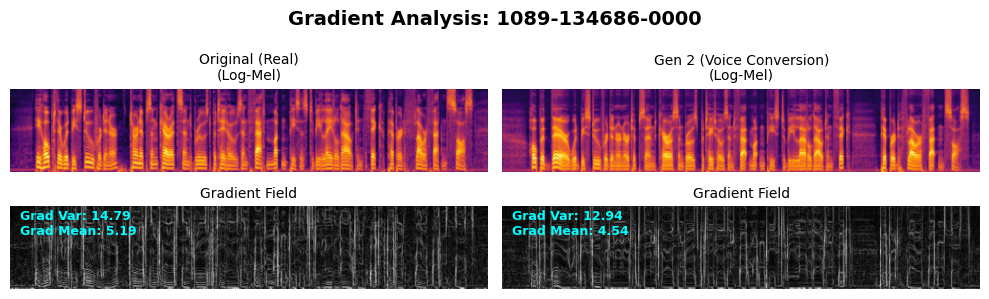

--- Analysis Report for 1089-134686-0000 ---
Real Audio Gradient Variance: 14.7907
[Gen 2 (Voice Conversion)] Diff from Real: -1.8552
--------------------------------------------------


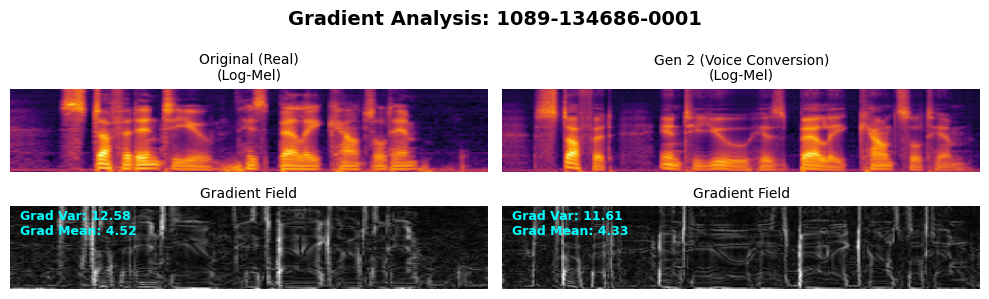

--- Analysis Report for 1089-134686-0001 ---
Real Audio Gradient Variance: 12.5803
[Gen 2 (Voice Conversion)] Diff from Real: -0.9679
--------------------------------------------------


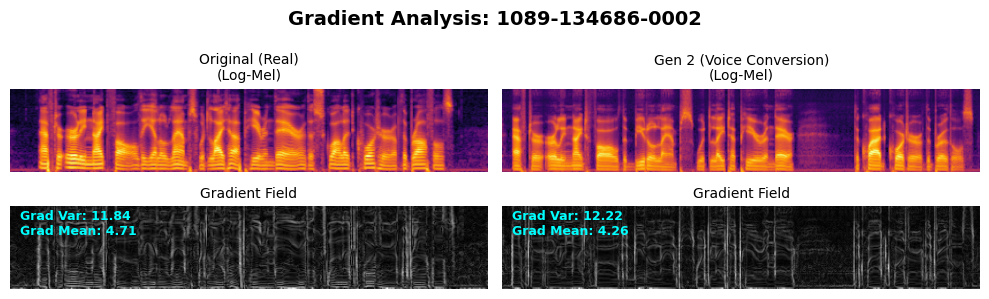

--- Analysis Report for 1089-134686-0002 ---
Real Audio Gradient Variance: 11.8414
[Gen 2 (Voice Conversion)] Diff from Real: 0.3794
--------------------------------------------------


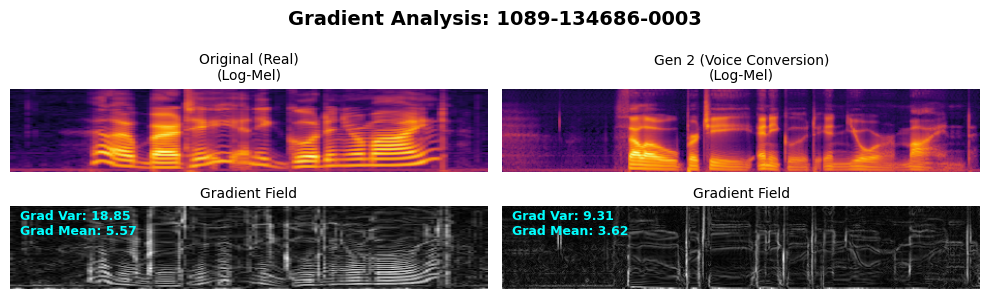

--- Analysis Report for 1089-134686-0003 ---
Real Audio Gradient Variance: 18.8482
[Gen 2 (Voice Conversion)] Diff from Real: -9.5408
--------------------------------------------------


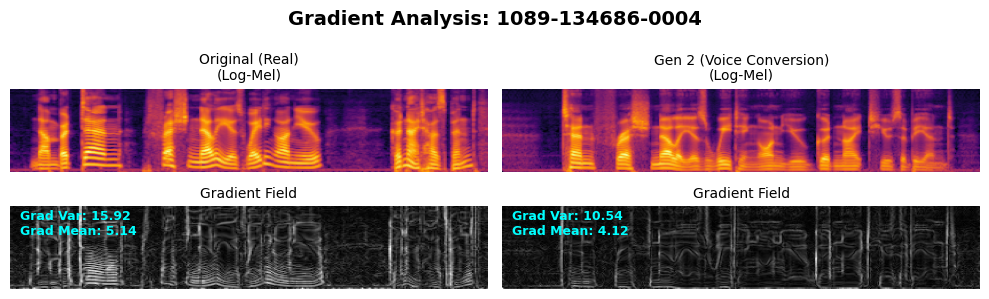

--- Analysis Report for 1089-134686-0004 ---
Real Audio Gradient Variance: 15.9219
[Gen 2 (Voice Conversion)] Diff from Real: -5.3780
--------------------------------------------------


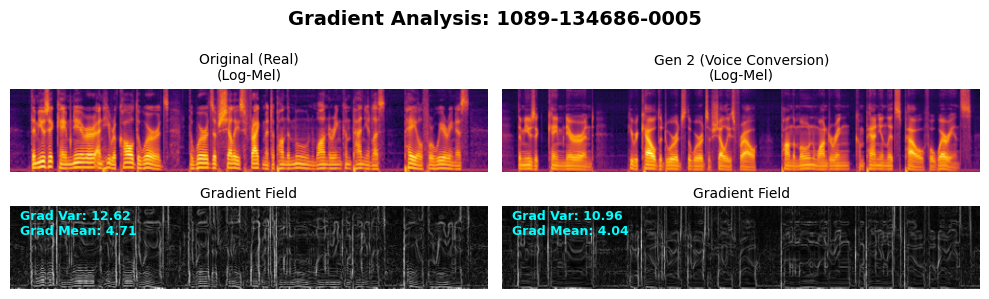

--- Analysis Report for 1089-134686-0005 ---
Real Audio Gradient Variance: 12.6217
[Gen 2 (Voice Conversion)] Diff from Real: -1.6663
--------------------------------------------------


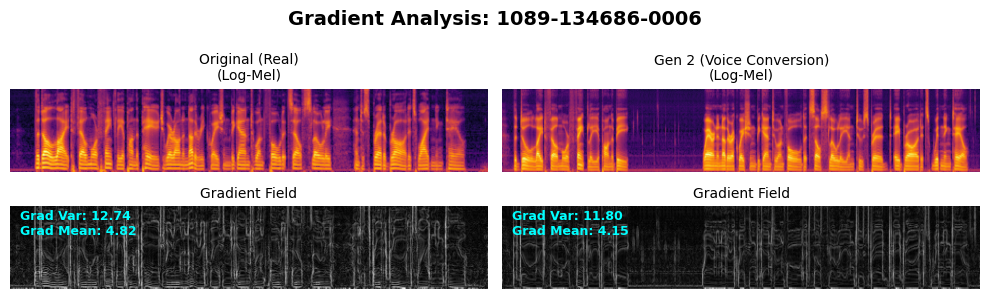

--- Analysis Report for 1089-134686-0006 ---
Real Audio Gradient Variance: 12.7444
[Gen 2 (Voice Conversion)] Diff from Real: -0.9447
--------------------------------------------------


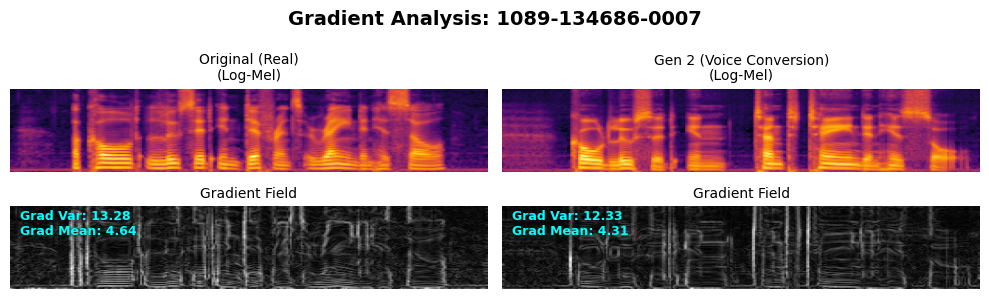

--- Analysis Report for 1089-134686-0007 ---
Real Audio Gradient Variance: 13.2849
[Gen 2 (Voice Conversion)] Diff from Real: -0.9555
--------------------------------------------------


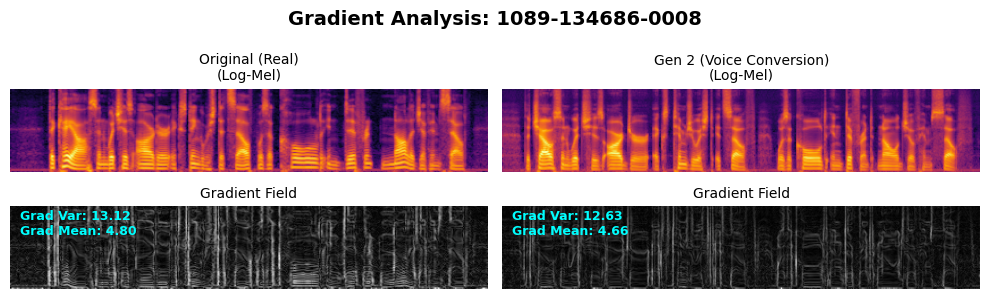

--- Analysis Report for 1089-134686-0008 ---
Real Audio Gradient Variance: 13.1154
[Gen 2 (Voice Conversion)] Diff from Real: -0.4811
--------------------------------------------------


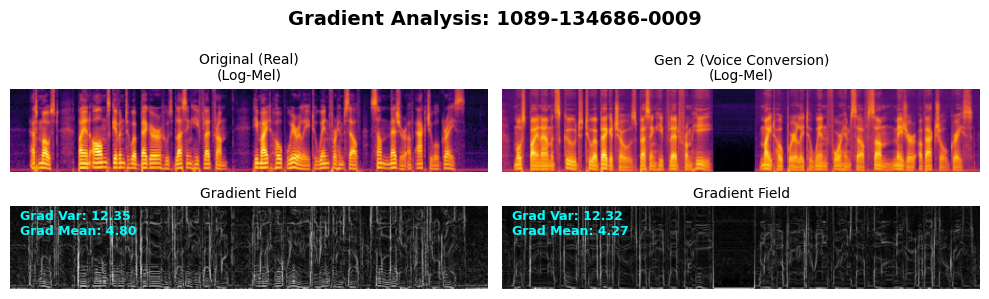

--- Analysis Report for 1089-134686-0009 ---
Real Audio Gradient Variance: 12.3545
[Gen 2 (Voice Conversion)] Diff from Real: -0.0305
--------------------------------------------------


In [22]:

#실행 예시 (dataframe_10이 정의되어 있다고 가정)
for row in dataframe_10.to_dict('records'):
    visualize_triplet_analysis(row)

Processed 10 rows...
Data collection complete. Plotting results...
Drawing arrows...


/mnt/fr20tb/kyudan/miniforge3/envs/deepfake/lib/python3.10/site-packages/torchaudio/_backend/utils.py:213: UserWarning: In 2.9, this function's implementation will be changed to use torchaudio.load_with_torchcodec` under the hood. Some parameters like ``normalize``, ``format``, ``buffer_size``, and ``backend`` will be ignored. We recommend that you port your code to rely directly on TorchCodec's decoder instead: https://docs.pytorch.org/torchcodec/stable/generated/torchcodec.decoders.AudioDecoder.html#torchcodec.decoders.AudioDecoder.
  warnings.warn(


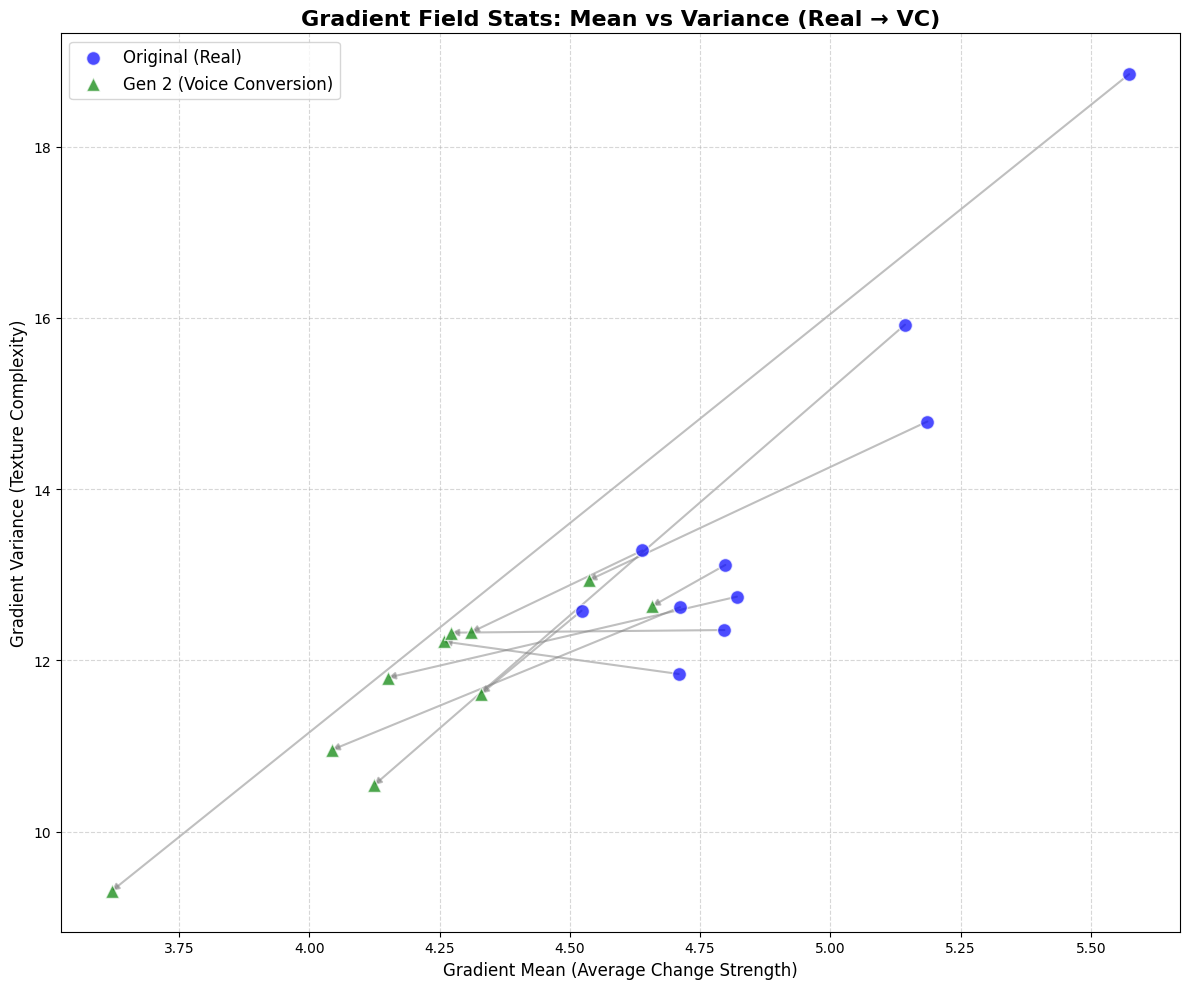

In [14]:
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path

# 데이터를 저장할 딕셔너리 (파일명 기준으로 매칭하기 위함)
# 구조: { 'file_name': {'Original': (mean, var), 'Gen 2': (mean, var)} }
file_metrics = {}

# 색상 및 마커 설정 (Gen 1 제외)
styles = {
    "Original (Real)": {'color': 'blue', 'marker': 'o', 'label': 'Original (Real)'},
    "Gen 2 (Voice Conversion)": {'color': 'green', 'marker': '^', 'label': 'Gen 2 (Voice Conversion)'}
}

print("Collecting data metrics...")

# dataframe_10의 모든 행에 대해 데이터 수집
for i, row in enumerate(dataframe_10.to_dict('records')):
    base_name = Path(row['audio_path']).stem
    
    # 딕셔너리 초기화
    if base_name not in file_metrics:
        file_metrics[base_name] = {}

    # 2가지 타입(Original, Gen 2)의 파일 경로 정의
    file_paths = {
        "Original (Real)": Path(row['audio_path']).resolve(),
        "Gen 2 (Voice Conversion)": Path(f"generated_results/speaker_libri_transcript_{base_name}.wav")
    }
    
    for group_name, path in file_paths.items():
        if not path.exists():
            continue
            
        # 1. Mel Spectrogram 계산
        mel = compute_mel_spectrogram(str(path))
        if mel is None:
            continue
            
        # 2. Gradient Field 수치 추출 (Mean, Variance)
        _, var, mean = compute_gradient_field(mel)
        
        # 3. 데이터 저장 (파일명 키 아래에 그룹별로 저장)
        file_metrics[base_name][group_name] = (mean, var)

    # 진행 상황 표시
    if (i + 1) % 10 == 0:
        print(f"Processed {i + 1} rows...")

print("Data collection complete. Plotting results...")

# --- 시각화 (Scatter Plot + Arrows) ---
plt.figure(figsize=(12, 10))

# 1. 점 찍기 (Scatter)
# 범례(Legend)를 위해 그룹별로 모아서 한 번씩 찍습니다.
for group_name in styles.keys():
    means = []
    vars = []
    
    for name, metrics in file_metrics.items():
        if group_name in metrics:
            means.append(metrics[group_name][0]) # mean
            vars.append(metrics[group_name][1])  # var
            
    if means:
        plt.scatter(means, vars, 
                    c=styles[group_name]['color'], 
                    marker=styles[group_name]['marker'], 
                    label=styles[group_name]['label'], 
                    alpha=0.7, s=100, edgecolors='white', zorder=2)

# 2. 화살표 그리기 (Arrows)
print("Drawing arrows...")
for name, metrics in file_metrics.items():
    # Original과 Gen 2 데이터가 둘 다 있는 경우에만 화살표 연결
    if "Original (Real)" in metrics and "Gen 2 (Voice Conversion)" in metrics:
        start_pos = metrics["Original (Real)"]         # (mean, var)
        end_pos = metrics["Gen 2 (Voice Conversion)"]  # (mean, var)
        
        plt.annotate(
            "", 
            xy=end_pos,            # 화살표 머리 (Gen 2)
            xytext=start_pos,      # 화살표 꼬리 (Original)
            arrowprops=dict(
                arrowstyle="-|>", 
                color='gray', 
                alpha=0.5, 
                linewidth=1.5,
                shrinkA=0, shrinkB=0
            ),
            zorder=1
        )

# 그래프 꾸미기
plt.title("Gradient Field Stats: Mean vs Variance (Real → VC)", fontsize=16, fontweight='bold')
plt.xlabel("Gradient Mean (Average Change Strength)", fontsize=12)
plt.ylabel("Gradient Variance (Texture Complexity)", fontsize=12)
plt.legend(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

Starting feature extraction for PCA (Original vs Gen 2)...
Feature extraction complete. Data shape: (20, 20480)
Running PCA...
Explained variance ratio: [0.11175289 0.07470204]
Drawing arrows...


/mnt/fr20tb/kyudan/miniforge3/envs/deepfake/lib/python3.10/site-packages/torchaudio/_backend/utils.py:213: UserWarning: In 2.9, this function's implementation will be changed to use torchaudio.load_with_torchcodec` under the hood. Some parameters like ``normalize``, ``format``, ``buffer_size``, and ``backend`` will be ignored. We recommend that you port your code to rely directly on TorchCodec's decoder instead: https://docs.pytorch.org/torchcodec/stable/generated/torchcodec.decoders.AudioDecoder.html#torchcodec.decoders.AudioDecoder.
  warnings.warn(


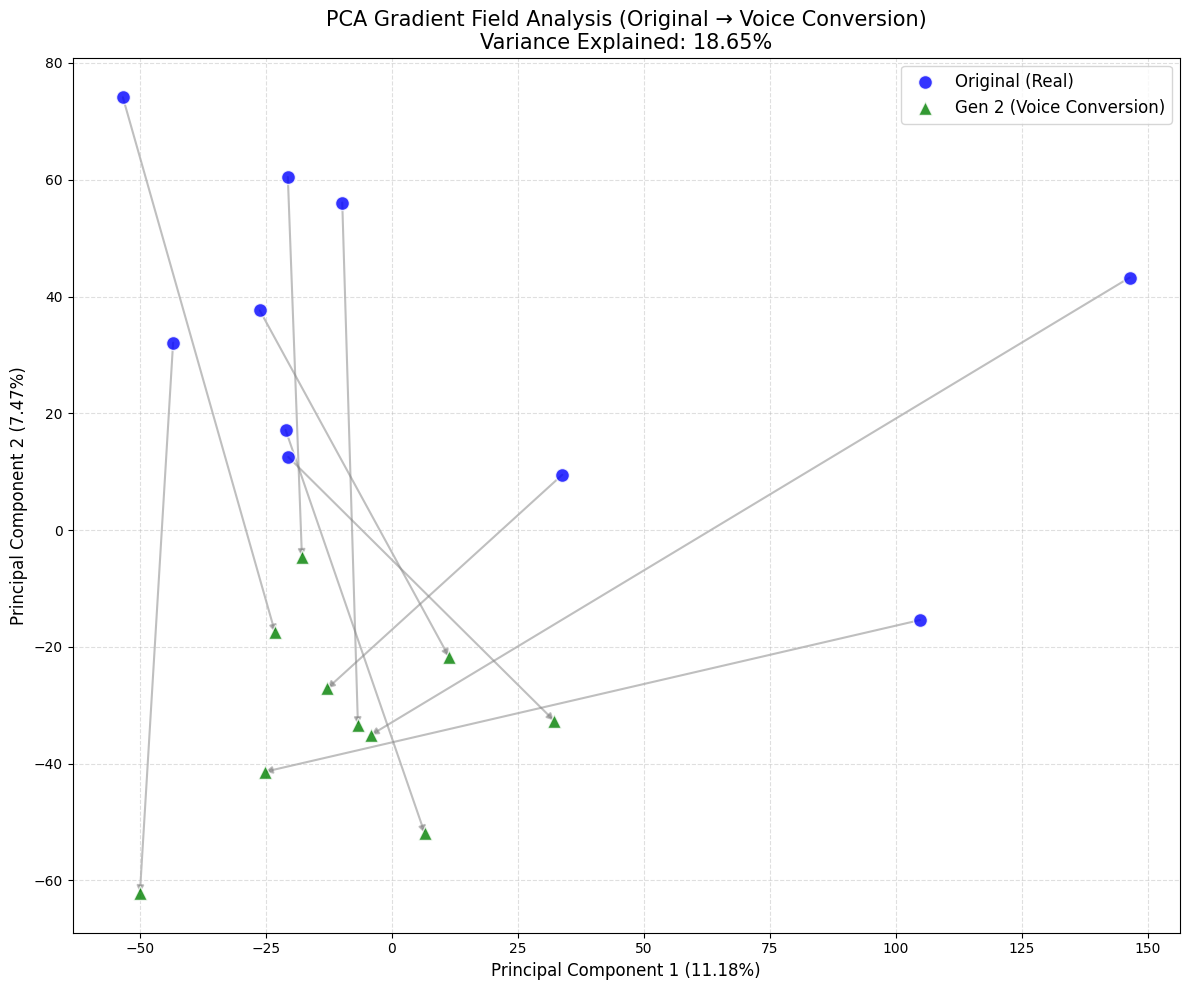

In [13]:
import matplotlib.pyplot as plt
import torchaudio
import torch
import numpy as np
from pathlib import Path
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# --- 1. 설정 및 헬퍼 함수 (기존과 동일) ---

TARGET_WIDTH = 256  

def resize_spectrogram(spec_tensor, target_width=TARGET_WIDTH):
    n_mels, width = spec_tensor.shape
    if width > target_width:
        start = (width - target_width) // 2
        return spec_tensor[:, start:start+target_width]
    elif width < target_width:
        pad_width = target_width - width
        return torch.nn.functional.pad(spec_tensor, (0, pad_width, 0, 0))
    return spec_tensor

def compute_mel_spectrogram_resized(audio_path, n_mels=80, target_width=TARGET_WIDTH):
    try:
        waveform, sr = torchaudio.load(audio_path)
        mel = torchaudio.transforms.MelSpectrogram(
            sample_rate=sr, n_fft=1024, hop_length=256, n_mels=n_mels, normalized=True
        )(waveform)
        mel_db = torchaudio.functional.amplitude_to_DB(mel, multiplier=10.0, amin=1e-10, db_multiplier=1.0)
        mel_db = mel_db.squeeze(0)
        return resize_spectrogram(mel_db, target_width)
    except Exception as e:
        print(f"Error loading {audio_path}: {e}")
        return None

def compute_flattened_gradient(mel_tensor):
    mel_np = mel_tensor.numpy()
    grad_y, grad_x = np.gradient(mel_np)
    gradient_magnitude = np.sqrt(grad_x**2 + grad_y**2)
    return gradient_magnitude.flatten()

# --- 2. 데이터 수집 (Original & Gen 2 Only) ---

features = [] 
labels = []   
filenames = [] # 화살표 연결을 위해 파일명 저장

# 분석할 대상 그룹 정의 (Gen 1 제외)
target_groups = ["Original (Real)", "Gen 2 (Voice Conversion)"]
label_map = {name: i for i, name in enumerate(target_groups)}
colors = ['blue', 'green'] # 파랑: 원본, 초록: 변환
markers = ['o', '^']

print("Starting feature extraction for PCA (Original vs Gen 2)...")

for i, row in enumerate(dataframe_10.to_dict('records')):
    base_name = Path(row['audio_path']).stem
    
    # 두 가지 경로만 설정
    file_paths = {
        "Original (Real)": Path(row['audio_path']).resolve(),
        "Gen 2 (Voice Conversion)": Path(f"generated_results/speaker_libri_transcript_{base_name}.wav")
    }
    
    for group_name, path in file_paths.items():
        if not path.exists(): continue
            
        mel = compute_mel_spectrogram_resized(str(path))
        if mel is None: continue
            
        flattened_vec = compute_flattened_gradient(mel)
        
        features.append(flattened_vec)
        labels.append(label_map[group_name])
        filenames.append(base_name) # 파일명 저장

X = np.array(features)
y = np.array(labels)

print(f"Feature extraction complete. Data shape: {X.shape}")

# --- 3. PCA 수행 ---

print("Running PCA...")
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

explained_variance = pca.explained_variance_ratio_
print(f"Explained variance ratio: {explained_variance}")

# --- 4. 시각화 (화살표 포함) ---

plt.figure(figsize=(12, 10))

# 4-1. 산점도 그리기
for target_idx, group_name in enumerate(target_groups):
    mask = (y == target_idx)
    plt.scatter(
        X_pca[mask, 0], 
        X_pca[mask, 1],
        color=colors[target_idx],
        marker=markers[target_idx],
        label=group_name,
        alpha=0.8, s=100, edgecolors='white',
        zorder=2
    )

# 4-2. 화살표 그리기 (Original -> Gen 2)
print("Drawing arrows...")
unique_files = sorted(list(set(filenames)))

for base_name in unique_files:
    # 현재 파일명에 해당하는 인덱스 찾기
    orig_indices = [idx for idx, (f, l) in enumerate(zip(filenames, labels)) if f == base_name and l == 0]
    gen2_indices = [idx for idx, (f, l) in enumerate(zip(filenames, labels)) if f == base_name and l == 1]

    if orig_indices and gen2_indices:
        start_pos = X_pca[orig_indices[0]] # Original 위치
        end_pos = X_pca[gen2_indices[0]]   # Gen 2 위치

        plt.annotate(
            "", 
            xy=end_pos, 
            xytext=start_pos,
            arrowprops=dict(
                arrowstyle="-|>", 
                color='gray', 
                alpha=0.5, 
                linewidth=1.5,
                shrinkA=0, shrinkB=0
            ),
            zorder=1
        )

# 그래프 꾸미기
plt.title(f"PCA Gradient Field Analysis (Original → Voice Conversion)\nVariance Explained: {sum(explained_variance)*100:.2f}%", fontsize=15)
plt.xlabel(f"Principal Component 1 ({explained_variance[0]*100:.2f}%)", fontsize=12)
plt.ylabel(f"Principal Component 2 ({explained_variance[1]*100:.2f}%)", fontsize=12)
plt.legend(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.4)

plt.tight_layout()
plt.show()

Extracting features...
Data shape: (20, 20480)
Running t-SNE (Perplexity: 19)...


/mnt/fr20tb/kyudan/miniforge3/envs/deepfake/lib/python3.10/site-packages/torchaudio/_backend/utils.py:213: UserWarning: In 2.9, this function's implementation will be changed to use torchaudio.load_with_torchcodec` under the hood. Some parameters like ``normalize``, ``format``, ``buffer_size``, and ``backend`` will be ignored. We recommend that you port your code to rely directly on TorchCodec's decoder instead: https://docs.pytorch.org/torchcodec/stable/generated/torchcodec.decoders.AudioDecoder.html#torchcodec.decoders.AudioDecoder.
  warnings.warn(


Drawing arrows...


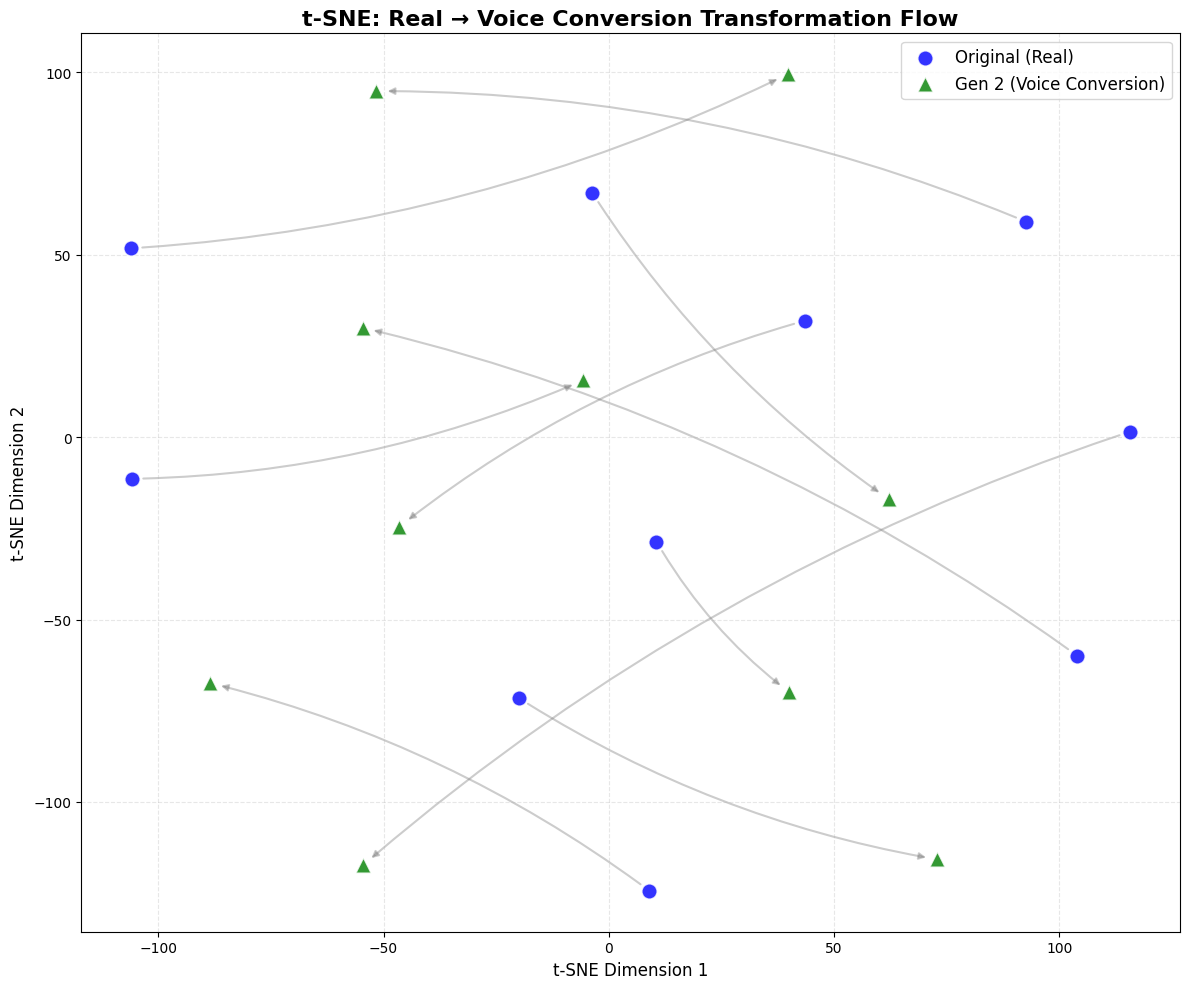

In [12]:
import matplotlib.pyplot as plt
import torchaudio
import torch
import numpy as np
from pathlib import Path
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# --- 1. 설정 및 헬퍼 함수 (기존과 동일) ---

TARGET_WIDTH = 256

def resize_spectrogram(spec_tensor, target_width=TARGET_WIDTH):
    n_mels, width = spec_tensor.shape
    if width > target_width:
        start = (width - target_width) // 2
        return spec_tensor[:, start:start+target_width]
    elif width < target_width:
        pad_width = target_width - width
        return torch.nn.functional.pad(spec_tensor, (0, pad_width, 0, 0))
    return spec_tensor

def compute_mel_and_flatten_grad(audio_path, n_mels=80):
    try:
        waveform, sr = torchaudio.load(audio_path)
        mel = torchaudio.transforms.MelSpectrogram(
            sample_rate=sr, n_fft=1024, hop_length=256, n_mels=n_mels, normalized=True
        )(waveform)
        mel_db = torchaudio.functional.amplitude_to_DB(mel, multiplier=10.0, amin=1e-10, db_multiplier=1.0)
        mel_resized = resize_spectrogram(mel_db.squeeze(0))
        mel_np = mel_resized.numpy()
        grad_y, grad_x = np.gradient(mel_np)
        grad_mag = np.sqrt(grad_x**2 + grad_y**2)
        return grad_mag.flatten()
    except Exception as e:
        return None

# --- 2. 데이터 수집 (Original vs Gen 2) ---

features = []
labels = []
filenames = [] # 화살표 연결을 위해 파일명 저장

target_groups = ["Original (Real)", "Gen 2 (Voice Conversion)"]
label_map = {name: i for i, name in enumerate(target_groups)}
colors = ['blue', 'green']
markers = ['o', '^']

print("Extracting features...")
for row in dataframe_10.to_dict('records'):
    base_name = Path(row['audio_path']).stem
    file_paths = {
        "Original (Real)": Path(row['audio_path']).resolve(),
        "Gen 2 (Voice Conversion)": Path(f"generated_results/speaker_libri_transcript_{base_name}.wav")
    }
    for group_name, path in file_paths.items():
        if not path.exists(): continue
        vec = compute_mel_and_flatten_grad(str(path))
        if vec is not None:
            features.append(vec)
            labels.append(label_map[group_name])
            filenames.append(base_name) # 파일명도 함께 저장

X = np.array(features)
y = np.array(labels)
print(f"Data shape: {X.shape}")

# --- 3. t-SNE 실행 ---

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

n_components_pca = min(50, len(X), X.shape[1])
pca = PCA(n_components=n_components_pca)
X_pca = pca.fit_transform(X_scaled)

perplexity_val = min(30, len(X) - 1)
print(f"Running t-SNE (Perplexity: {perplexity_val})...")
tsne = TSNE(n_components=2, perplexity=perplexity_val, random_state=42, init='pca', learning_rate='auto')
X_embedded = tsne.fit_transform(X_pca)

# --- 4. 시각화 (화살표 추가) ---

plt.figure(figsize=(12, 10)) # 화살표가 잘 보이도록 크기 증가

# 4-1. 점 찍기 (산점도)
for idx, group_name in enumerate(target_groups):
    mask = (y == idx)
    plt.scatter(
        X_embedded[mask, 0], X_embedded[mask, 1],
        c=colors[idx], label=group_name, marker=markers[idx],
        s=120, alpha=0.8, edgecolors='white',
        zorder=2 # 화살표 위에 점이 오도록 순서 지정
    )

# 4-2. 화살표 그리기 (Original -> Gen 2)
print("Drawing arrows...")
# 중복 없는 파일명 리스트 추출
unique_files = sorted(list(set(filenames)))

for base_name in unique_files:
    # 현재 파일명에 해당하는 Original(label=0)과 Gen 2(label=1)의 데이터 인덱스 찾기
    orig_indices = [i for i, (f, l) in enumerate(zip(filenames, labels)) if f == base_name and l == 0]
    gen2_indices = [i for i, (f, l) in enumerate(zip(filenames, labels)) if f == base_name and l == 1]

    # 쌍이 온전하게 존재할 경우에만 화살표 그리기
    if orig_indices and gen2_indices:
        start_pos = X_embedded[orig_indices[0]] # 시작점 (Original 좌표)
        end_pos = X_embedded[gen2_indices[0]]   # 끝점 (Gen 2 좌표)

        # 화살표 그리기
        plt.annotate(
            "",  # 텍스트 내용 없음
            xy=end_pos,           # 화살표 머리 위치
            xytext=start_pos,     # 화살표 꼬리 위치
            arrowprops=dict(
                arrowstyle="-|>",         # 뾰족한 화살표 모양
                color='gray',             # 화살표 색상
                alpha=0.4,                # 투명도 (너무 진하면 방해됨)
                linewidth=1.5,            # 선 두께
                shrinkA=8, shrinkB=8,     # 점과 화살표 사이 여백 주기
                connectionstyle="arc3,rad=0.1" # 약간 휘어진 화살표 (직선이 좋으면 이 줄 삭제)
            ),
            zorder=1 # 점 아래에 그려지도록 설정
        )

# 4-3. 그래프 꾸미기
plt.title("t-SNE: Real → Voice Conversion Transformation Flow", fontsize=16, fontweight='bold')
plt.xlabel("t-SNE Dimension 1", fontsize=12)
plt.ylabel("t-SNE Dimension 2", fontsize=12)
plt.legend(fontsize=12, loc='upper right')
plt.grid(True, linestyle='--', alpha=0.3)

plt.tight_layout()
plt.show()